## Tweet Analysis (Scalable Data Processing)
In this notebook, I aim to demonstrate scalable data processing that is independent of pandas. I am going to use Pyspark library which is more efficient and scalable for big data processing and machine learning production.    
#### Bottlenecks for Pandas processing:   
1. Memory handling. pandas capitalizes on data locality and operates on a single node in the memory with minimal data movement. This process becomes severely limiting when the dataset spans from megabytes to giga/terabytes. Pandas is designed to be efficient with small dataset. Pyspark operates on java virtual machine which distributes data across several nodes for more efficient processing.
2. Vectorisation: In NLP, vectorisation is a core preprocessing stage that leads to sparse matrix. Pandas is not efficient in vectorisation and therefore can handle a limited number of features. HashingTF uses a fixed-size feature space (2^18) whihc bounds memory and avoids building a vocabulary.
3. Grouping Data tables. Spark has more capacity to apply more complex grouping of data accross several datatables with efficient filtering which can not be performed in a single sequence with pandas.
4. Lazy execution: Spark employs lazy execution unlike pandas for memory efficiency. Transformations in pyspark are only executed when they are called by action and results can be cached without the need for repeated computing.
5. Latency and real time processing:  Pyspark is optimised for real time processing and streaming which is not applicable in pandas.
6. Transformations in pyspark run by partitioning and parallelism. Steps such as join, groupby, orderby. Pandas is serial by nature and therefore processes involving ETL and columnar operations are severely limiting.

#### About the Data
The dataset contains over a million tweets from users which has been rated as positive or negative. The goal is prepare and train a model for classification using pyspark, save and reload the model to predict data. The second objective is to compare the performance of a Baseline model (Logistic Regression) which uses only the text features, against a second model which combines the text features with numeric features.

##### Result
With the addition of numeric features to the training data, the model performance increased only by 1%. The absence of significant changes in the results from text only features and numeric plus text features is because the text features already dominate the signal, adding a few numeric features barely shifted the decision boundary. Logistic regression needs careful regularisation parameter  and maximum iteration tuning for stable convergence.  

Due to windows hadoop limitation, the trained model could not be saved through pipelineModel. However, the predictions and the pipeline model parameters were persisted through duckdb database and json for deterministic retraining and reproducibility of the model.  If the model is deployed properly on linux or with proper Hadoop winutils setup, I will persist the model with pipelineModel() or use MLflow model logging.

In [1]:
## importing library and setting up the environment
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *
import pandas as pd
import numpy as np
from pyspark.sql.functions import col, sum

In [2]:
spark = (
    SparkSession.builder
    .appName("SentimentAnalysis")
    .config("spark.driver.memory", "5g")
    .config("spark.executor.memory", "3g")
    .config("spark.executor.cores", "2")
    .config("spark.sql.shuffle.partitions", "24")
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer")
    .getOrCreate()
)


Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
26/02/07 19:02:27 WARN Utils: Your hostname, DESKTOP-IKUPD53, resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
26/02/07 19:02:27 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/02/07 19:02:28 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
import pyspark
print("PySpark version:", pyspark.__version__)
print("Spark version:", spark.version)


PySpark version: 4.1.1
Spark version: 4.1.1


In [4]:
schema = StructType([
    StructField('Target', IntegerType(), True),
    StructField('ID', LongType(), True),
    StructField('Date', StringType(), True),
    StructField('flag', StringType(), True),
    StructField('User', StringType(), True),
    StructField('Text', StringType(), True)
    ])


df = (spark.read
      .format('csv')
      .option('encoding', 'ISO-8859-1')
      .option('header', 'true')
      .schema(schema)
      .load('tweets.csv')
     )

## viewing the first few columns
df.show(3, truncate=80)      

+------+----------+----------------------------+--------+-------------+--------------------------------------------------------------------------------+
|Target|        ID|                        Date|    flag|         User|                                                                            Text|
+------+----------+----------------------------+--------+-------------+--------------------------------------------------------------------------------+
|     0|1467810672|Mon Apr 06 22:19:49 PDT 2009|NO_QUERY|scotthamilton|is upset that he can't update his Facebook by texting it... and might cry as ...|
|     0|1467810917|Mon Apr 06 22:19:53 PDT 2009|NO_QUERY|     mattycus|@Kenichan I dived many times for the ball. Managed to save 50%  The rest go o...|
|     0|1467811184|Mon Apr 06 22:19:57 PDT 2009|NO_QUERY|      ElleCTF|                                 my whole body feels itchy and like its on fire |
+------+----------+----------------------------+--------+-------------+-----------

In [5]:
#printing the shape of the dataframe
print('Shape: (%s, %s)' % (df.count(), len(df.columns)))

[Stage 1:>                                                          (0 + 8) / 8]

Shape: (1048575, 6)


In [6]:
#column names
df.columns

['Target', 'ID', 'Date', 'flag', 'User', 'Text']

In [7]:
#date types as set in the schema
df.dtypes

[('Target', 'int'),
 ('ID', 'bigint'),
 ('Date', 'string'),
 ('flag', 'string'),
 ('User', 'string'),
 ('Text', 'string')]

In [8]:
##Checking the number of null rows in each column
null_counts = df.select([sum(F.isnull(col(c)).cast('int')).alias(c) for c in df.columns])
null_counts.show()

[Stage 4:====================================>                      (5 + 3) / 8]

+------+---+----+----+----+----+
|Target| ID|Date|flag|User|Text|
+------+---+----+----+----+----+
|     0|  0|   0|   0|   0|   0|
+------+---+----+----+----+----+



### Data Cleaning

##### date column

In [9]:
#cleaning the date columns and removing the time zones
df = (df.withColumn('clean_date', F.regexp_replace(col('Date'), r'(?<=:\d{2}) (?:[A-Za-z])* (?=\d){2,4}', ' '))
      .withColumn('clean_date', F.regexp_replace('clean_date', r'\s+', ' '))
     )

#printing the date columns
df.select('Date', 'clean_date').show(5, truncate=30)

+----------------------------+------------------------+
|                        Date|              clean_date|
+----------------------------+------------------------+
|Mon Apr 06 22:19:49 PDT 2009|Mon Apr 06 22:19:49 2009|
|Mon Apr 06 22:19:53 PDT 2009|Mon Apr 06 22:19:53 2009|
|Mon Apr 06 22:19:57 PDT 2009|Mon Apr 06 22:19:57 2009|
|Mon Apr 06 22:19:57 PDT 2009|Mon Apr 06 22:19:57 2009|
|Mon Apr 06 22:20:00 PDT 2009|Mon Apr 06 22:20:00 2009|
+----------------------------+------------------------+
only showing top 5 rows


In [10]:
## getting the length of the datetime string values
print(df.first().clean_date)
print("length: %s" % len(df.first().clean_date))

Mon Apr 06 22:19:49 2009
length: 24


In [11]:
## checking the date span on the tail of dataframe
df.tail(3)

[Row(Target=4, ID=1960186429, Date='Fri May 29 07:33:44 PDT 2009', flag='NO_QUERY', User='Falchion', Text='@ShaDeLa same here  say it like from the Terminiator movies. comes off like just 3 words. :-D', clean_date='Fri May 29 07:33:44 2009'),
 Row(Target=4, ID=1960186445, Date='Fri May 29 07:33:44 PDT 2009', flag='NO_QUERY', User='jonasobsessedx', Text='@DestinyHope92 im great thaanks  wbuu?', clean_date='Fri May 29 07:33:44 2009'),
 Row(Target=4, ID=1960186607, Date='Fri May 29 07:33:45 PDT 2009', flag='NO_QUERY', User='sugababez', Text='cant wait til her date this weekend ', clean_date='Fri May 29 07:33:45 2009')]

####
In working with the datecolumn, Pyspark version 3+ and above does not have a native support for parsing the day (eg Mon, Tue) through timestamp.  For consistency with version requirements and to avoid deprecation problems in future, I will substring the clean date column and only parse the accepted timestamp format in pyspark

In [12]:
## Converting the date column . Sunday is 1 and saturday is 7 

df2 = (df.withColumn('formatted_date', F.to_timestamp(df.clean_date.substr(5, 24), 'MMM dd HH:mm:ss yyyy'))
       .withColumn('hour', F.hour('formatted_date'))
       .withColumn('dayofweek', F.dayofweek('formatted_date'))
      )

##### Text column

In [13]:
#a look at the text column
df2.select('Text').show(5, truncate=False)

+---------------------------------------------------------------------------------------------------------------+
|Text                                                                                                           |
+---------------------------------------------------------------------------------------------------------------+
|is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!|
|@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds                      |
|my whole body feels itchy and like its on fire                                                                 |
|@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there. |
|@Kwesidei not the whole crew                                                                                   |
+---------------------------------------------------------------------------------------

In [14]:
df2 = (df2.withColumn('clean_text', F.lower(col('Text')))
       .withColumn('clean_text', F.regexp_replace('clean_text', r'http\S+|www\.\S+', ' '))
       .withColumn('clean_text', F.regexp_replace('clean_text', r'@\w+', ' '))
       .withColumn('clean_text', F.regexp_replace('clean_text', r'[^a-z0-9\s]', ' '))
       .withColumn('clean_text', F.regexp_replace('clean_text', r'\s+', ' '))
       .withColumn('clean_text', F.trim('clean_text'))
      )

In [15]:
## verifying unique values in flag column
df2.select('flag').distinct().show()

[Stage 12:=======>                                                  (1 + 7) / 8]

+--------+
|    flag|
+--------+
|NO_QUERY|
+--------+



#### Generating features from the clean text column
The following features will be added. character count, word count and number of exclamations which expresses emotion

In [16]:
## getting the number of words in text 
df2 = (df2.withColumn('char_count', F.expr('length(clean_text)'))
       .withColumn('total_words', F.size(F.split('clean_text', ' ')))
       .withColumn('num_exclaim', F.length('Text') - F.length(F.regexp_replace('Text', '!', '')))
      )
    

df2.select('clean_text', 'char_count', 'total_words', 'num_exclaim').show(3, truncate=50)

[Stage 15:>                                                         (0 + 1) / 1]

+--------------------------------------------------+----------+-----------+-----------+
|                                        clean_text|char_count|total_words|num_exclaim|
+--------------------------------------------------+----------+-----------+-----------+
|is upset that he can t update his facebook by t...|       105|         22|          1|
|i dived many times for the ball managed to save...|        76|         17|          0|
|    my whole body feels itchy and like its on fire|        46|         10|          0|
+--------------------------------------------------+----------+-----------+-----------+
only showing top 3 rows


##### Converting the target column to binary 0 and 1

In [17]:
# updating the target column to 0 and 1 binary values
df2.select('Target').distinct().show()

+------+
|Target|
+------+
|     0|
|     4|
+------+



In [18]:
df2 = df2.withColumn('target_reaction', F.when(df2.Target == 0, 0).otherwise(1))

In [19]:
df2.groupby('target_reaction').count().show()

+---------------+------+
|target_reaction| count|
+---------------+------+
|              0|799999|
|              1|248576|
+---------------+------+



In [20]:
df2.groupby('Target').count().show()

+------+------+
|Target| count|
+------+------+
|     0|799999|
|     4|248576|
+------+------+



#### Caching the cleaned dataframe

In [21]:
from pyspark.storagelevel import StorageLevel

In [22]:
##Selecting only columns that will be used for data modelling
tweet_df = df2.select('hour', 'dayofweek', 
                     'char_count', 'total_words',
                     'num_exclaim',  'clean_text', 'target_reaction')
tweet_df.persist(StorageLevel.MEMORY_AND_DISK)
tweet_df.count()

1048575

I cached the cleaned dataframe above after all the expensive teext and date transformations and materialized it with count opearator so that it will compute all text and date transformations . This is to ensure that further downstream processes like EDA, plotting and modelling will reuse the memory instead of recomputing the transformations which uses lots of memory

In [23]:
tweet_df.show(5, truncate=20)

+----+---------+----------+-----------+-----------+--------------------+---------------+
|hour|dayofweek|char_count|total_words|num_exclaim|          clean_text|target_reaction|
+----+---------+----------+-----------+-----------+--------------------+---------------+
|  22|        2|       105|         22|          1|is upset that he ...|              0|
|  22|        2|        76|         17|          0|i dived many time...|              0|
|  22|        2|        46|         10|          0|my whole body fee...|              0|
|  22|        2|        88|         23|          0|no it s not behav...|              0|
|  22|        2|        18|          4|          0|  not the whole crew|              0|
+----+---------+----------+-----------+-----------+--------------------+---------------+
only showing top 5 rows


#### Data visualisation
for memory optimisation, i will sample a fraction of the dataframe for visualisations

In [24]:
tweet_sample = (tweet_df
                .sample(fraction=0.01, seed=44)
                .toPandas()
               )

In [25]:
tweet_sample.head(2)

,hour,dayofweek,char_count,total_words,num_exclaim,clean_text,target_reaction
0,22,2,22,4,0,poor cameron the hills,0
1,22,2,119,25,9,dang another spring break how cool is that too...,0


In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

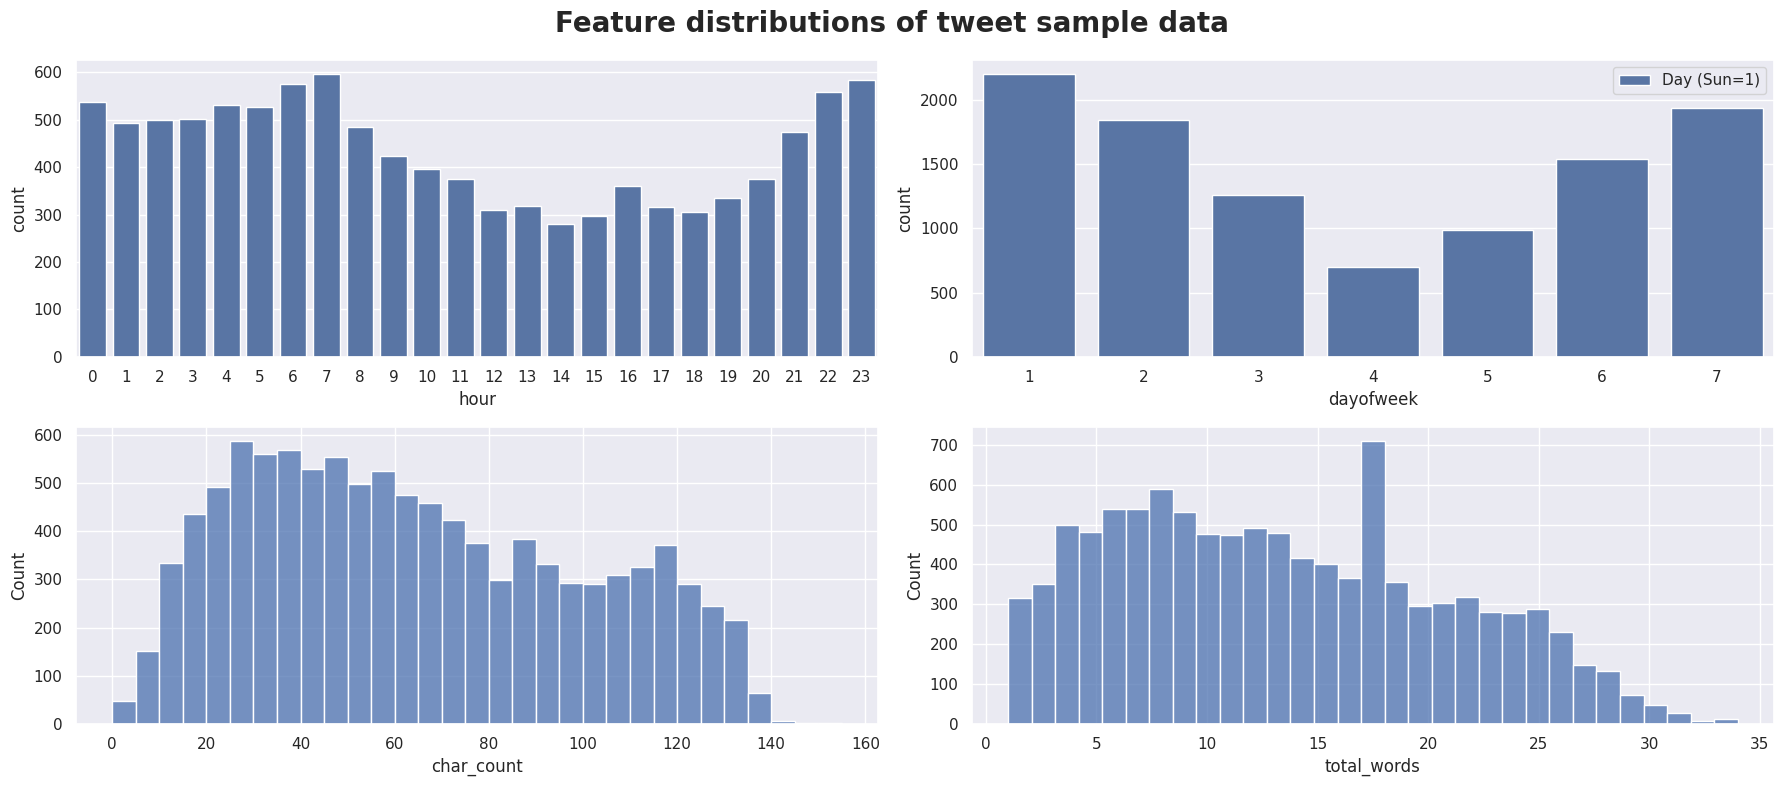

In [27]:
fig, axes = plt.subplots(2, 2, figsize=(18, 8))
axd = axes.ravel()
sns.countplot(data=tweet_sample, x='hour', ax=axd[0])
sns.countplot(data=tweet_sample, x='dayofweek', ax=axd[1], label='Day (Sun=1)')
sns.histplot(data=tweet_sample, x='char_count', ax=axd[2])
sns.histplot(data=tweet_sample, x='total_words', ax=axd[3])

plt.subplots_adjust(bottom=0.2, top=0.3, wspace=0.2, hspace=0.4)

plt.suptitle('Feature distributions of tweet sample data', fontweight='semibold', fontsize=20)
plt.tight_layout()
plt.show()

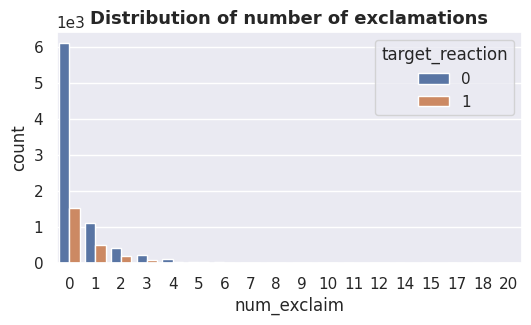

In [28]:
## plotting the exclamation distribution

fig, ax = plt.subplots(figsize=(6,3))
sns.countplot(data=tweet_sample, x='num_exclaim', hue='target_reaction',ax=ax)
ax.set_title('Distribution of number of exclamations', fontsize=13, fontweight='semibold')
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

plt.show()

### Data Modelling
I will compare two models using logistic regression.  The first will be a baseline model which only uses text features. The second will be a model that uses text and numeric features whose aim is to compare whether the numeric features add any improvements to the baseline model.

In [29]:
print(f"Current partitions: {tweet_df.rdd.getNumPartitions()}")

Current partitions: 8


In [30]:
## splitting date to train and test
train, test = tweet_df.randomSplit(weights=[0.8, 0.2], seed=44)

`Because the train and test split is not stratified, i will confirm the distribution of the classes in the train and test split to ensure that both classes are adequate in the split`

In [31]:
test_class = test.groupby('target_reaction').count()
train_class = train.groupby('target_reaction').count()

In [32]:
## showing the distribution of the classes in the train and test split
test_count = test_class.toPandas()
train_count = train_class.toPandas()
train_count.rename(columns={'count': 'train'}, inplace=True)
test_count.rename(columns={'count':'test'}, inplace=True)

class_distribution = pd.merge(train_count, test_count, how='inner', on='target_reaction')

class_distribution.set_index('target_reaction')

,train,test
target_reaction,,
0,640213,159786
1,198805,49771


In [33]:
## repartitioning test data for better memory efficiency
train = train.repartition(200).cache()
test = test.repartition(20)
train.count()

839018

In [34]:
from pyspark.ml.feature import (RegexTokenizer,
                                StopWordsRemover,
                                HashingTF,
                                IDF, 
                                VectorAssembler,
                                StandardScaler
)
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator


In [35]:
class Assemble_and_Model:
   
    def __init__(self, use_numeric_features = False, train=None, test=None, 
                 persist_level=StorageLevel.MEMORY_AND_DISK):
        
        self.use_numeric_features = use_numeric_features
        self.pipeline = None
        self.train = train
        self.test = test
        self.prediction = None

        self.persist_level = persist_level
        
        self.lr = LogisticRegression(featuresCol='features', 
                                     labelCol='target_reaction', 
                                     weightCol = 'class_weight', 
                                     maxIter=100, 
                                     regParam=0.1,
                                    elasticNetParam=0.0)
        
        self.numeric_features = ['hour', 'dayofweek', 'char_count', 'total_words', 'num_exclaim']
        self.train_idf = None
        self.test_idf = None
        self.train_w = None

    def numeric_assembler(self):
        numeric_vec = VectorAssembler(inputCols=self.numeric_features,
                                      outputCol='num_features', handleInvalid='keep')
        scaled_num = StandardScaler(inputCol='num_features', outputCol='scaled_num_vector', withMean=False)
        return numeric_vec, scaled_num

    def prepare_text(self):
        """ this function persists the tokenized text features to memory 
        to avoid recomputing """
        n_classes = 2
        if self.train_idf is not None and self.train_w is not None:
            return self
        
        tokenizer = RegexTokenizer(inputCol = 'clean_text', 
                               outputCol='word_token', 
                              pattern='\\W+', 
                              minTokenLength=2)
    
        token_filter = StopWordsRemover(inputCol='word_token', outputCol='token_nostops')
        hashed = HashingTF(inputCol='token_nostops', outputCol='hashed_token', numFeatures=2**16)
        tfidf = IDF(minDocFreq=5, inputCol='hashed_token', outputCol='tfidf_token')
        idf_pipe = Pipeline(stages= [tokenizer, token_filter, hashed, tfidf])
    
        train_idf_model = idf_pipe.fit(self.train)
        train_t = train_idf_model.transform(self.train)
        test_t = train_idf_model.transform(self.test)
    
        cols_keep = ['target_reaction', 'tfidf_token'] + self.numeric_features
    
        train_t = train_t.select(*cols_keep)
        test_t = test_t.select(*cols_keep)

        #persisting to memory
        self.train_idf = train_t.persist(self.persist_level)
        self.test_idf = test_t.persist(self.persist_level)

        ## materialising
        _ = self.train_idf.count()
        _ = self.test_idf.count()

        ## computing class weights
        counts = (self.train_idf
          .groupBy('target_reaction')
          .count()
          .collect())
        
        count_map = {row['target_reaction']: row['count'] for row in counts}
        n_total = list(count_map.values())[0] + list(count_map.values())[1]
        n_classes = 2
        
        class_1_total = count_map.get(1, 0)
        class_0_total = count_map.get(0, 0)

        if class_0_total == 0 or class_1_total == 0:
            raise ValueError(f"Unexpected labels or missing class. Found counts: {count_map}")
        
        weight_1 = n_total / (class_1_total * n_classes)
        weight_0 = n_total / (class_0_total * n_classes)

        

        self.train_w = (self.train_idf
                        .withColumn('class_weight', F.when(F.col('target_reaction') == 1, F.lit(weight_1)).otherwise(F.lit(weight_0)))
                        .persist(self.persist_level)
                        )
        _ = self.train_w.count()

        return self
        
    
    def build_pipeline(self):
        
        self.prepare_text()
        
        if self.pipeline is None:      
            if self.use_numeric_features:
                numeric_vec, scaled_num = self.numeric_assembler()
                assembler = VectorAssembler(inputCols=['tfidf_token', 'scaled_num_vector'], outputCol='features')
                self.pipeline = Pipeline(stages = [numeric_vec, scaled_num, assembler, self.lr])
                
            else:
                assembler = VectorAssembler(inputCols=['tfidf_token'], outputCol='features')
                self.pipeline = Pipeline(stages= [assembler, self.lr])
            
        return self.pipeline

    def fit(self):
        self.prepare_text()
        self.pipeline = self.build_pipeline()
        self.model = self.pipeline.fit(self.train_w)
        return self
        
    def transform(self):
        if self.model is None:
            raise ValueError('Model is not fitted. Call fit() first')
        self.prediction = self.model.transform(self.test_idf)
        return self

    def evaluate(self):
        if self.prediction is None:
            self.transform()
            
        auc_evaluator = BinaryClassificationEvaluator(
                        rawPredictionCol='rawPrediction',
                        labelCol='target_reaction',
                        metricName='areaUnderROC')
        f1_evaluator = MulticlassClassificationEvaluator(
                            predictionCol='prediction', 
                            labelCol='target_reaction',
                            metricName='f1')
        acc_evaluator = MulticlassClassificationEvaluator(
                            predictionCol='prediction', 
                            labelCol='target_reaction',
                            metricName='accuracy')
        
        auc = auc_evaluator.evaluate(self.prediction)
        f1_score = f1_evaluator.evaluate(self.prediction)
        accuracy = acc_evaluator.evaluate(self.prediction)

        return auc, f1_score, accuracy

    def unpersist_tfidf(self):
        if self.train_idf is not None:
            self.train_idf.unpersist()
        if self.test_idf is not None:
            self.test_idf.unpersist()
        if self.train_w is not None:
            self.train_w.unpersist()
        return self
        

#### Baseline Model (Text features Only)

In [36]:
Base_model = Assemble_and_Model(train=train, test=test)   ## text only model 

full_model = Assemble_and_Model(train=train, test=test, use_numeric_features=True)  # text + numeric features model

## computing TFIDF 
Base_model.prepare_text()

26/02/07 19:03:15 WARN DAGScheduler: Broadcasting large task binary with size 1082.7 KiB
26/02/07 19:03:19 WARN DAGScheduler: Broadcasting large task binary with size 1087.7 KiB
26/02/07 19:03:21 WARN DAGScheduler: Broadcasting large task binary with size 1074.9 KiB
26/02/07 19:03:22 WARN DAGScheduler: Broadcasting large task binary with size 1081.6 KiB
26/02/07 19:03:22 WARN DAGScheduler: Broadcasting large task binary with size 1099.9 KiB
26/02/07 19:03:23 WARN DAGScheduler: Broadcasting large task binary with size 1092.7 KiB
26/02/07 19:03:24 WARN DAGScheduler: Broadcasting large task binary with size 1097.7 KiB
                                                                                

In [37]:
# fitting text only model
Base_model.fit()

26/02/07 19:03:26 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
26/02/07 19:03:31 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
26/02/07 19:03:32 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
26/02/07 19:03:32 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
26/02/07 19:03:32 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
26/02/07 19:03:37 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
26/02/07 19:03:38 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
26/02/07 19:03:38 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
26/02/07 19:03:41 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
26/02/07 19:03:42 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
26/02/07 19:03:42 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
26/02/07 19:03:45 WARN DAGSchedul

In [38]:
baseline_prediction = Base_model.transform()

In [39]:
base_auc, base_f1, base_accuracy = Base_model.evaluate()

26/02/07 19:04:37 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
26/02/07 19:04:41 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
26/02/07 19:04:43 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
                                                                                

In [40]:
print('Base Model with Text features only metrics')
print(f'AUC {base_auc:.2f} \nF1_score {base_f1:.2f} \naccuracy {base_accuracy:.2f}')

Base Model with Text features only metrics
AUC 0.84 
F1_score 0.78 
accuracy 0.77


In [41]:
baseline_prediction.prediction.select('target_reaction', 'probability', 'prediction').show(10, truncate=15)

+---------------+---------------+----------+
|target_reaction|    probability|prediction|
+---------------+---------------+----------+
|              0|[0.735162004...|       0.0|
|              0|[0.578866525...|       0.0|
|              0|[0.872207554...|       0.0|
|              0|[0.795797387...|       0.0|
|              0|[0.861803320...|       0.0|
|              0|[0.755558778...|       0.0|
|              0|[0.619486169...|       0.0|
|              0|[0.210553513...|       1.0|
|              0|[0.726286348...|       0.0|
|              0|[0.809703493...|       0.0|
+---------------+---------------+----------+
only showing top 10 rows


26/02/07 19:04:44 WARN DAGScheduler: Broadcasting large task binary with size 1550.2 KiB


In [42]:
cm = (baseline_prediction.prediction
      .select(F.col('target_reaction').cast('int').alias('label'),
              F.col('prediction').cast('int').alias('pred'))
      .groupBy('label', 'pred')
      .count()
     )

cm_baseline = (cm
               .groupBy('label')
               .pivot('pred')
               .sum('count')
               .na.fill(0)
               .orderBy('label')
              )
cm_baseline.show()


26/02/07 19:04:44 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
26/02/07 19:04:45 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
26/02/07 19:04:45 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
26/02/07 19:04:46 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
26/02/07 19:04:46 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
26/02/07 19:04:47 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB


+-----+------+-----+
|label|     0|    1|
+-----+------+-----+
|    0|121991|37795|
|    1| 11392|38379|
+-----+------+-----+



26/02/07 19:04:48 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
                                                                                

In [43]:
# Calculating true positives, true negatives, false positives, false negatives
tp_baseline = baseline_prediction.prediction.filter((col('target_reaction') == 1) & (col('prediction') == 1)).count()
tn_baseline = baseline_prediction.prediction.filter((col('target_reaction') == 0) & (col('prediction') == 0)).count()
fp_baseline = baseline_prediction.prediction.filter((col('target_reaction') == 0) & (col('prediction') == 1)).count()
fn_baseline = baseline_prediction.prediction.filter((col('target_reaction') == 1) & (col('prediction') == 0)).count()


# Calculating precision
precision_baseline = tp_baseline / (tp_baseline + fp_baseline) if (tp_baseline + fp_baseline) != 0 else 0  
print(f"Precision (text only): {precision_baseline:.2g}")

# Calculating recall
recall_baseline = tp_baseline / (tp_baseline + fn_baseline) if (tp_baseline + fn_baseline) != 0 else 0.0  
print(f"Recall (text only): {recall_baseline:.2g}")


26/02/07 19:04:48 WARN DAGScheduler: Broadcasting large task binary with size 1547.1 KiB
26/02/07 19:04:48 WARN DAGScheduler: Broadcasting large task binary with size 1547.1 KiB
26/02/07 19:04:49 WARN DAGScheduler: Broadcasting large task binary with size 1547.1 KiB
26/02/07 19:04:50 WARN DAGScheduler: Broadcasting large task binary with size 1547.1 KiB


Precision (text only): 0.5
Recall (text only): 0.77


### Baseline plus numeric features model
For the numeric features in the model, i have added the following columns: 
1. hour
2. dayofweek
3. char_count
4. total_words
5. num_exclaim    

I expect that these columns might shift the decision boundary to get improved prediction outcome. However, it may also be possible that the text features has dominated the model that there is no significant improvement from the numeric features

In [44]:
### fitting the full model
full_model.fit()

26/02/07 19:04:54 WARN DAGScheduler: Broadcasting large task binary with size 1082.7 KiB
26/02/07 19:04:57 WARN DAGScheduler: Broadcasting large task binary with size 1087.7 KiB
26/02/07 19:04:58 WARN DAGScheduler: Broadcasting large task binary with size 1075.0 KiB
26/02/07 19:04:59 WARN DAGScheduler: Broadcasting large task binary with size 1081.6 KiB
26/02/07 19:05:00 WARN DAGScheduler: Broadcasting large task binary with size 1100.0 KiB
26/02/07 19:05:00 WARN DAGScheduler: Broadcasting large task binary with size 1092.7 KiB
26/02/07 19:05:02 WARN DAGScheduler: Broadcasting large task binary with size 1097.7 KiB
26/02/07 19:05:02 WARN DAGScheduler: Broadcasting large task binary with size 1119.3 KiB
26/02/07 19:05:04 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
26/02/07 19:05:11 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
26/02/07 19:05:12 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
26/02/07 19:05:12 WARN DAGSche

In [45]:
full_model_prediction = full_model.transform()

In [46]:
fulldata_auc, fulldata_f1, fulldata_accuracy = full_model.evaluate()

26/02/07 19:06:22 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
26/02/07 19:06:24 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
26/02/07 19:06:25 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
                                                                                

In [47]:
print('Text plus Numeric Features model metrics results')
print(f'AUC {fulldata_auc:.2f} \nf1_score {fulldata_f1:.2f}, \naccuracy {fulldata_accuracy:.2f}')

Text plus Numeric Features model metrics results
AUC 0.85 
f1_score 0.79, 
accuracy 0.77


In [48]:
full_model_prediction.prediction.select('target_reaction', 'probability', 'prediction').show(10, truncate=15)

+---------------+---------------+----------+
|target_reaction|    probability|prediction|
+---------------+---------------+----------+
|              0|[0.684542126...|       0.0|
|              0|[0.618744372...|       0.0|
|              0|[0.893213884...|       0.0|
|              0|[0.822942555...|       0.0|
|              0|[0.821158343...|       0.0|
|              0|[0.790826446...|       0.0|
|              0|[0.589329668...|       0.0|
|              0|[0.232849928...|       1.0|
|              0|[0.730450418...|       0.0|
|              0|[0.774013742...|       0.0|
+---------------+---------------+----------+
only showing top 10 rows


26/02/07 19:06:27 WARN DAGScheduler: Broadcasting large task binary with size 1571.4 KiB


In [49]:
confusionmatrix = (full_model_prediction.prediction
 .select(F.col('target_reaction').cast('int').alias('label'),
         F.col('prediction').cast('int').alias('pred'))
 .groupBy('label', 'pred').count()
                  )

matrix_pivot = (confusionmatrix.groupBy('label')
                .pivot('pred')
                .sum('count')
                .na.fill(0)
                .orderBy('label')
               )
matrix_pivot.show()

26/02/07 19:06:27 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
26/02/07 19:06:28 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
26/02/07 19:06:29 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
26/02/07 19:06:29 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
26/02/07 19:06:29 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
26/02/07 19:06:31 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB


+-----+------+-----+
|label|     0|    1|
+-----+------+-----+
|    0|123386|36400|
|    1| 11308|38463|
+-----+------+-----+



26/02/07 19:06:31 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
                                                                                

In [50]:
# Calculating true positives, true negatives, false positives, false negatives
tp_fulldata = full_model_prediction.prediction.filter((col('target_reaction') == 1) & (col('prediction') == 1)).count()
tn_fulldata = full_model_prediction.prediction.filter((col('target_reaction') == 0) & (col('prediction') == 0)).count()
fp_fulldata = full_model_prediction.prediction.filter((col('target_reaction') == 0) & (col('prediction') == 1)).count()
fn_fulldata = full_model_prediction.prediction.filter((col('target_reaction') == 1) & (col('prediction') == 0)).count()


# Calculating precision
precision_fulldata = tp_fulldata / (tp_fulldata + fp_fulldata) if (tp_fulldata + fp_fulldata) != 0 else 0  
print(f"Precision (text+numeric): {precision_fulldata:.2g}")

# Calculating recall
recall_fulldata = tp_fulldata / (tp_fulldata + fn_fulldata) if (tp_fulldata + fn_fulldata) != 0 else 0.0  
print(f"Recall (text+numeric): {recall_fulldata:.2g}")



26/02/07 19:06:31 WARN DAGScheduler: Broadcasting large task binary with size 1567.8 KiB
26/02/07 19:06:32 WARN DAGScheduler: Broadcasting large task binary with size 1567.8 KiB
26/02/07 19:06:33 WARN DAGScheduler: Broadcasting large task binary with size 1567.8 KiB
26/02/07 19:06:33 WARN DAGScheduler: Broadcasting large task binary with size 1567.8 KiB


Precision (text+numeric): 0.51
Recall (text+numeric): 0.77


In [51]:
model_results = [
    {'model_type':'Text_only', 
     'AUC':f'{base_auc:.2f}',
     'F1': f'{base_f1:.2f}',
     'Accuracy': f'{base_accuracy:.2f}',
     'Precision': f'{precision_baseline:.2f}', 
     'Recall': f'{recall_baseline:.2f}'
     
    }, 
    {'model_type':'Text_plus_numeric',
     'AUC': f'{fulldata_auc:.2f}', 
     'F1': f'{fulldata_f1:.2f}', 
     'Accuracy': f'{fulldata_accuracy:.2f}',
    'Precision': f'{precision_fulldata:.2f}', 
    'Recall': f'{recall_fulldata:.2f}'
}
]

model_result = pd.DataFrame(model_results)
model_result.set_index('model_type')

,AUC,F1,Accuracy,Precision,Recall
model_type,,,,,
Text_only,0.84,0.78,0.77,0.50,0.77
Text_plus_numeric,0.85,0.79,0.77,0.51,0.77


In [52]:
## unpersisting the data from memory 
tweet_df.unpersist()
Base_model.unpersist_tfidf()


#### Model saving
After the heavy data processing and model fitting, I will like to persist the model by saving it for future use in order not to recompute the entire preprocessing and pipeline when predicting the model.  Persisting the model also means the model is reusable at anytime without worrying about the preprocssing and training the model.

I will be saving the model that used both text and numeric features. ie `full_model'. One thing to note is that the pipeline model is stateful. It therefore means that it is unable to take test input independently for evaluation or prediction. This will be refactored when engineering the pipeline for ML deployment.

As well, I will be persisting the model preprocessing parameters/stages and the evaluation results as json file.  

In [53]:
import json

lr_stage = full_model.model.stages[-1]   
payload = {
    "intercept": float(lr_stage.intercept),
    "coefficients": lr_stage.coefficients.toArray().tolist(),
    "numFeatures": int(2**16),
    "minDocFreq": 5,
    'token_pattern' :'\\W+', 
    'minTokenLength' : 2,
    'stopwordslanguage' : 'english',
    'labelmapping' : '0-1, 4-1',
    'train_test_split': (80, 20),
    'seed': 44,
    'auc' : fulldata_auc,
    'f1_score' : fulldata_f1, 
    'accuracy' : fulldata_accuracy,
    "notes": "HashingTF+IDF+LR (Spark), exported weights only Text+numeric features model"
}

with open("tweet_lr_weights.json", "w") as f:
    json.dump(payload, f)


In [54]:
model = full_model.model


In [56]:
model.write().overwrite().save("/home/user/spark_models/tweet_classification")

In [58]:
from pyspark.ml.pipeline import PipelineModel
reloaded_model = PipelineModel.load("/home/user/spark_models/tweet_classification")


## Reflection on the date process and model results
##### Result
With the addition of numeric features to the training data, the model performance increased only by 1%. The absence of significant changes in the results from text only features and numeric plus text features is because the text features already dominate the signal, adding a few numeric features barely shifted the decision boundary. Logistic regression needs careful regularisation parameter  and maximum iteration tuning for stable convergence.  .

1. What was slow/heavy in memory in pandas for this dataset? Loading the dataset of 1.4M rows to the RAM using pandas would have overpowered the memory but this was done easily with Pyspark.
2. What transformations were easiest in Spark, which were annoying?: Column transformations on Date and Text columns were parallelized easily for the dataset. Feature extractions were easily implemented using sql functions of spark. The limiting steps were, pyspark version 3 does not implement the same timestamplegacy as with version 2. Therefore i had to substring the date conversions which means that for future data proceessing, the data string will need to be consistent in format to be able to be processed without errors. This would not have been a problem in pandas. Also, spark is not designed for plotting so I had to sample some of the data to pandas dataframe for visualisation. If i wanted to extract more features from the visualisation, this might be a limitation.
3. Why did i choose HashingTF and IDF: Hashing in parallelized and has constant memory with compact representation. The output vector size is predefined making it possible to represent large features in a smaller space.  The text features are hashed and their values are represented in a lower dimension saving memory unlike countvectorizers.
4. How spark pipeline persistence differs from sklearn joblib?: Spark pipeline models are JVM objects and not python objects entirely. Joblib work with sklearn because they are purely python objects.
5. What will break at 10X data?: At 10X the dataset I have currently, the memory will break on the local machine because although the data is partitioned, each memory can only take as much. At 10X the current data, it will be ideal to migrate to a machine with more memory.
6. Would I keep Spark in the inference path or export to smaller service?: I would in this case export to a smaller service with an API like fastAPI or kubernetes as APIs are fast and the model can be used in production. Since I am not doing consistent batch processing, keeping the data in the inference path serves little purpose. 